## Sieci głębokie CNN

#### Opracowanie: Stanisław Osowski, Robert Szmurło, Edytował: Szymon Kuś  
16.06.2021r.

Sieci głębokie CNN stanowią połączenie nienadzorowanej ekstrakcji cech diagnostycznych obrazu (warstwy ukryte lokalnie połączone) z właściwym klasyfikatorem w końcowej części struktury sieciowej w pełni połączonej. Na wejście sieci podawane są oryginalne obrazy. Sieć CNN automatycznie generuje cechy diagnostyczne, które są procesowane przez w pełni połączone warstwy klasyfikatora właściwego.

W badaniach korzystać będziemy z techniki  „transfer learning”, czyli sieci wstępnie nauczonej na uniwersalnym (bardzo dużym) zbiorze danych, która podlega douczeniu na aktualnie analizowanym zbiorze obrazów. W tym podejściu uczeniu podlega jedynie część sieci w pełni połączona stanowiąca klasyfikator właściwy.

Badania dotyczyć będą zbioru fotografii twarzy. Jeden zbiór stanowią obrazy w skali szarości, drugi – obrazy kolorowe RGB. Maksymalna liczebność pierwszego zbioru to 68 klas, drugiego – 240. Dla polepszenia dokładności stosuje się zespół klasyfikatorów zintegrowanych na zasadzie głosowania większościowego.


Badanie CNN na bazie obrazów w skali szarości

* Zapoznać się z bazą danych obrazów: ALEX_obrazy20
* Dołączyć do sprawozdania po jednym reprezentancie każdej klasy obrazów
* Przeprowadzić badania skuteczności uczenia dla bazy fotografii w skali szarości ograniczonej do 20 klas. Przeprowadzić 4 próby uczenia, notując wyniki dla poszczególnych prób, ich średniej oraz zespołu klasyfikatorów zintegrowanych w trybie głosowania większościowego. Wyniki zanotować w stosownej tabeli.

Definiujemy zbiory danych, na których będziemy uczyć i testować nasz model.

In [1]:
from itertools import chain

numbers = range(10)

uppercase_latin = range(10, 36)
uppercase_polish = range(36, 45)
uppercase = chain(uppercase_latin, uppercase_polish)

lowercase_latin = range(45, 71)
lowercase_polish = range(71, 80)
lowercase = chain(lowercase_latin, lowercase_polish)

letters = chain(uppercase, lowercase)
latin_letters = chain(uppercase_latin, lowercase_latin)
polish_letters = chain(uppercase_polish, lowercase_polish)

special_characters = range(80, 112)
whitespaces = range(112, 115)

non_letters = chain(numbers, special_characters, whitespaces)

full_dataset = range(115)

**Wybieramy podzbiór:**

In [2]:
dataset = list(full_dataset) #mozna wybrac cokolowiek z powyzszych

Tworzymy funkcję konwertującą numer znaku na znak:

In [3]:
def classno_to_char(ind):
    polish_letters = list("ĄĆĘŁŃÓŚŹŻ")
    polish_miniscule_letters = list("ąćęłńóśźż")
    
    if ind < 10:
        return str(ind)
    elif ind < 36:
        return chr(ord('A') + ind - 10)
    elif ind < 45:
        return polish_letters[ind - 36]
    elif ind < 71:
        return chr(ord('a') + ind - 45)
    elif ind < 80:
        return polish_miniscule_letters[ind - 71]
    elif ind < 95:
        return chr(ord('!') + ind - 80)
    elif ind < 102:
        return chr(ord(':') + ind - 95)
    elif ind < 108:
        return chr(ord('[') + ind - 102)
    elif ind < 112:
        return chr(ord('{') + ind - 108)
    elif ind == 112:
        return ' '
    elif ind == 113:
        return '\t'
    else:
        return "\n"

def classno_to_charname(ind):
    char = classno_to_char(ind)
    if char == ' ':
        return 'space'
    elif char == '\t':
        return 'tab'
    elif char == '\n':
        return 'newline'
    else:
        return char

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
import matplotlib.pyplot as plt
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import pandas as pd

plt.rc('font', size=6)

dataset_folder = "data/images"

Wyświetlimy listę podfolderów, których nazwy jednocześnie definiują definiują etykiety klas uczących.

In [5]:
os.listdir(dataset_folder)

FileNotFoundError: [WinError 3] System nie może odnaleźć określonej ścieżki: 'data/sub000/images'

Zdefiniujemy funkcję wczytującą obrazy z zadanego folderu.

In [66]:
def read_images(folder=dataset_folder):
    from keras.preprocessing.image import load_img
    from keras.preprocessing.image import img_to_array

    images_list=[]
    target_list=[]
    folder = dataset_folder
    for sub in dataset:
        for im in next(os.walk(os.path.join(folder,str(sub))))[2]:

            # load the image
            img = load_img(os.path.join(folder,str(sub),im))
            # print("Original:", type(img))

            # convert to numpy array
            img_array = img_to_array(img)
            # print(img_array.shape)
            images_list.append(img_array)
            target_list.append(list(dataset).index(sub))

    images = np.array(images_list)
    target = np.array(target_list)
    return images, target

Wczytujemy obrazy.

In [67]:
images, labels = read_images()
display(images.shape)
display(labels.shape)

(2535, 28, 28, 3)

(2535,)

Korzystamy z funkcji `interact` aby interaktywnie przeglądać wczytane 400 zdjęć.

In [68]:
from ipywidgets import interact

In [70]:
@interact(idx=(0,images.shape[0]-1,1))
def show_image(idx):
    img = images[idx,:,:,:]
    #display(img)
    plt.imshow(img.astype(np.uint8))
    plt.title(f"Klasa: {dataset[labels[idx]]}")

#show_image(100)

interactive(children=(IntSlider(value=1267, description='idx', max=2534), Output()), _dom_classes=('widget-int…

Dzielimy wczytany zbiór danych na trzy części: dane uczące, walidujące oraz testowe. Skorzystamy z funkcji `scikitlearn`, aby wybór danych był automatycznie losowy. Dane będą odpowiednio wymieszane z wszystkich klas. 

In [71]:
from sklearn.model_selection import train_test_split

train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2)
train_images, validation_images, train_labels, validation_labels = train_test_split(train_images, train_labels, test_size=0.2)

print(f"Rozmiar danych uczących:      {train_images.shape}")
print(f"Rozmiar danych walidujących:  {validation_images.shape}")
print(f"Rozmiar danych testujących:   {test_images.shape}")
print(f"Rozmiar etykiet uczących:     {train_labels.shape}")
print(f"Rozmiar etykiet walidujących: {validation_labels.shape}")
print(f"Rozmiar etykiet testujących:  {test_labels.shape}")


Rozmiar danych uczących:      (1622, 28, 28, 3)
Rozmiar danych walidujących:  (406, 28, 28, 3)
Rozmiar danych testujących:   (507, 28, 28, 3)
Rozmiar etykiet uczących:     (1622,)
Rozmiar etykiet walidujących: (406,)
Rozmiar etykiet testujących:  (507,)


Tworzymy obiekty do których będzie owoływać się Keras w celu pobierania porcji danych. Obiekty są dostosowane do pobierania danych w porcjach (batch), udostęþniania danych do procesora GPU, rozpraszania danych między wieloma węzłami obliczenowymi.

In [72]:
train_ds = tf.data.Dataset.from_tensor_slices( (train_images, train_labels) )
test_ds =  tf.data.Dataset.from_tensor_slices( (test_images, test_labels) )
validation_ds =  tf.data.Dataset.from_tensor_slices( (validation_images, validation_labels) )

Zapamiętujmy rozmiary danych w zmiennych pomocnicznych.

In [73]:
train_ds_size = tf.data.experimental.cardinality(train_ds).numpy()
test_ds_size = tf.data.experimental.cardinality(test_ds).numpy()
validation_ds_size = tf.data.experimental.cardinality(validation_ds).numpy()

print(f"Training data size: {train_ds_size}")
print(f"Test data size: {test_ds_size}")
print(f"Validation data size: {validation_ds_size}")

Training data size: 1622
Test data size: 507
Validation data size: 406


Definiujemy funkcję, która przeprowadzi standaryzację obrazów wejściowych (-1.7... do 1.7...) oraz przeskaluje obrazy do wymiaru zgodnego z siecią AlexNet (z  uwagi na konfigurację wejść sieci obrazy muszą być rozmiarów 227x227 pixeli)

In [74]:
def process_images(image, label):
    image = tf.image.per_image_standardization(image)
    image = tf.image.resize(image, [227,227] )
    return image, label

Tworzymy potoki (ang. pipes), których zadaniem jest przetwarzanie obrazów w locie, uworzenie porcji (batchów) oraz losowe wybieranie danych ze zbioru (`shuffle`).

In [75]:
train_ds = (train_ds
            .map(process_images)
            .shuffle(buffer_size=train_ds_size)
            .batch(batch_size=32, drop_remainder=True))
test_ds = (test_ds
            .map(process_images)
            .shuffle(buffer_size=test_ds_size)
            .batch(batch_size=32, drop_remainder=True))
validation_ds = (validation_ds
            .map(process_images)
            .shuffle(buffer_size=validation_ds_size)
            .batch(batch_size=32, drop_remainder=True))

Tworzymy funkcję zwracającą pustą konfguruję modelu z architekturą sieci AlexNet. Zgodnie z:

![AlexNet](https://cloud.ee.pw.edu.pl/nextcloud/index.php/s/ftKqCd4QnW4Ssge/download)

(W naszym przypadku, drobna różnica jest w pierwszej warstwie, gdyż używamy obrazów o rozmiarach 227 na 227 a nie 224 na 224).

Trzy ostatnie warstwy modelu stanowią oryginalny klasyfikator, który zignorujemy w naszym modelu.

In [76]:
def AlexNet():
    NUMBER_OF_CLASSES = 1000
    return keras.models.Sequential([
        keras.layers.Conv2D(name='conv1', filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3)),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
        keras.layers.Conv2D(name='conv2', filters=256, kernel_size=(5,5), strides=1, activation='relu', padding="same", groups=2),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
        keras.layers.Conv2D(name='conv3', filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(name='conv4', filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same", groups=2),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(name='conv5', filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same", groups=2),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
        keras.layers.Flatten(),
        keras.layers.Dense(4096, name='fc6', activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(4096, name='fc7', activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(NUMBER_OF_CLASSES, name='fc8', activation='softmax')
    ])

In [77]:
# tworzymy model

model = AlexNet()
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 55, 55, 96)        34944     
_________________________________________________________________
batch_normalization_5 (Batch (None, 55, 55, 96)        384       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 27, 27, 256)       307456    
_________________________________________________________________
batch_normalization_6 (Batch (None, 27, 27, 256)       1024      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 256)       0         
_________________________________________________________________
conv3 (Conv2D)               (None, 13, 13, 384)      

Pobieramy wartości wag nauczonej sieci AlexNet. Oryginalne źródło danych http://www.cs.toronto.edu/~guerzhoy/tf_alexnet/bvlc_alexnet.npy

Wczytujemy plik ze słownikiem numpy. Zawierającym macierze z wagami poszczegó→lnych warstw sieci AlexNet.

In [78]:
net_data = np.load(open("bvlc_alexnet.npy", "rb"), encoding="latin1", allow_pickle=True).item()

In [79]:
net_data.keys()

dict_keys(['fc6', 'fc7', 'fc8', 'conv3', 'conv2', 'conv1', 'conv5', 'conv4'])

In [80]:
# tutaj możemy przyjrzeć się strukturze wag.
len(net_data['conv1'][0])

11

Poniżej ustawiamy wagi z oryginalnego AlexNeta nauczone na milionach obrazów z tysiącem różnych klas.

In [81]:
model.get_layer('conv1').set_weights(net_data["conv1"])
model.get_layer('conv2').set_weights(net_data["conv2"])
model.get_layer('conv3').set_weights(net_data["conv3"])
model.get_layer('conv4').set_weights(net_data["conv4"])
model.get_layer('conv5').set_weights(net_data["conv5"])

model.get_layer('fc6').set_weights(net_data["fc6"])
model.get_layer('fc7').set_weights(net_data["fc7"])
model.get_layer('fc8').set_weights(net_data["fc8"])


In [82]:
# sama architektura sieci nie uległa zmianie, wcyztaliśmy wyłącznie wagi.

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 55, 55, 96)        34944     
_________________________________________________________________
batch_normalization_5 (Batch (None, 55, 55, 96)        384       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 27, 27, 256)       307456    
_________________________________________________________________
batch_normalization_6 (Batch (None, 27, 27, 256)       1024      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 256)       0         
_________________________________________________________________
conv3 (Conv2D)               (None, 13, 13, 384)      

Kopiujemy tyko warstwy konwolucyjne odpowiedzialne za ekstrakcję cech i włącznie z warstwą flatten (która zamienia nam wielowymiarowe wyjście na wektor jednowymiarowy). To będzie wejście ostatecznego klasyfikatora.

In [83]:
new_model = tf.keras.models.Sequential(model.layers[:-5])
new_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 55, 55, 96)        34944     
_________________________________________________________________
batch_normalization_5 (Batch (None, 55, 55, 96)        384       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 27, 27, 256)       307456    
_________________________________________________________________
batch_normalization_6 (Batch (None, 27, 27, 256)       1024      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 256)       0         
_________________________________________________________________
conv3 (Conv2D)               (None, 13, 13, 384)      

Blokujemy uczenie dla warstw konwolucyjnych, aby nie zniszczyć oryginlanie nauczonej sieci. Dodatkowo, przyspieszymy uczenie i polegamy na ekstracji cech z już nauczonej sieci. (Idea transfer learningu)

In [84]:
for l in new_model.layers:
    l.trainable = False

In [85]:
# tylko upewniamy się czy blokada uczenia została zapamiętana

for l in new_model.layers:
    print(l.trainable)

False
False
False
False
False
False
False
False
False
False
False
False
False
False


Automatycznie liczymy liczbę unikalnych klas w zbiorze uczącym.

In [86]:
numClasses = np.unique(train_labels).shape[0]
numClasses

115

Kopiujemy warstwy konwolucyjne z AlexNeta i dodajemy wałsne warstwy klasyfikacyjne.

In [87]:
i = 1
layers = new_model.layers + [
        keras.layers.Dense(500+35*i, activation='relu'),      
        keras.layers.Dropout(0.2+0.23*np.random.uniform(0,1)),  
        keras.layers.Dense(numClasses, activation='softmax')
    ]
    

new_model_transfer = tf.keras.models.Sequential(layers)
layers

Kompilujemy model z optymalizatorem stochastycznym największego spadku (ang. Stochastic Gradient Descent). 

Ustalamy Learning Rate (lr)

In [88]:

new_model_transfer.compile(loss='sparse_categorical_crossentropy', 
                           optimizer=tf.optimizers.SGD(lr=0.005), 
                           metrics=['accuracy'])
new_model_transfer.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 55, 55, 96)        34944     
_________________________________________________________________
batch_normalization_5 (Batch (None, 55, 55, 96)        384       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 27, 27, 256)       307456    
_________________________________________________________________
batch_normalization_6 (Batch (None, 27, 27, 256)       1024      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 256)       0         
_________________________________________________________________
conv3 (Conv2D)               (None, 13, 13, 384)      

G:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Tworzymy narzędzie do augmentacji danych w którym definiujemy cztery rodzaje augmentacji.

In [89]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#help(ImageDataGenerator)
datagen = ImageDataGenerator(rotation_range=10, 
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.1
                             )
datagen.fit(train_images)

Konwertujemy obrazy do odpowiedniego rozmiaru - zgodnego z wejściem AlexNeta.

In [90]:
train_images_processed = []
for img, lbl in zip(train_images, train_labels):
    i,l = process_images(img,lbl)
    train_images_processed.append(i)
train_images_processed = np.array( train_images_processed )
#train_images_processed

dtype('float32')

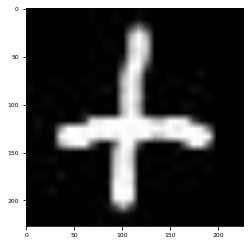

In [91]:
# tylko sprawdzmy czy wszystko poszło ok.
img = train_images_processed[1,:,:,:].copy()
img = (img -np.min(img)) * 255 / (np.max(img) - np.min(img))
plt.imshow(img.astype(np.uint8))
train_images_processed.dtype

In [92]:
# uczenie z augmentacją
history = new_model_transfer.fit(datagen.flow(train_images_processed, train_labels, batch_size=16), epochs=50, validation_data=validation_ds,
          validation_freq=1)

# uczenie bez augmentacji
#new_model_transfer.fit(train_ds, epochs=40, validation_data=validation_ds,
#          validation_freq=1)

Epoch 1/50
102/102 [==============================] - 16s 151ms/step - loss: 4.3797 - accuracy: 0.1005 - val_loss: 3.3799 - val_accuracy: 0.3307
Epoch 2/50
102/102 [==============================] - 15s 147ms/step - loss: 3.2955 - accuracy: 0.2719 - val_loss: 2.2607 - val_accuracy: 0.6172
Epoch 3/50
102/102 [==============================] - 16s 152ms/step - loss: 2.4958 - accuracy: 0.4223 - val_loss: 1.6214 - val_accuracy: 0.7109
Epoch 4/50
102/102 [==============================] - 15s 147ms/step - loss: 2.0109 - accuracy: 0.5253 - val_loss: 1.1630 - val_accuracy: 0.7708
Epoch 5/50
102/102 [==============================] - 16s 152ms/step - loss: 1.6539 - accuracy: 0.6048 - val_loss: 0.9152 - val_accuracy: 0.8255
Epoch 6/50
102/102 [==============================] - 15s 147ms/step - loss: 1.4590 - accuracy: 0.6467 - val_loss: 0.7160 - val_accuracy: 0.8594
Epoch 7/50
102/102 [==============================] - 15s 147ms/step - loss: 1.2249 - accuracy: 0.6893 - val_loss: 0.5804 - val_ac

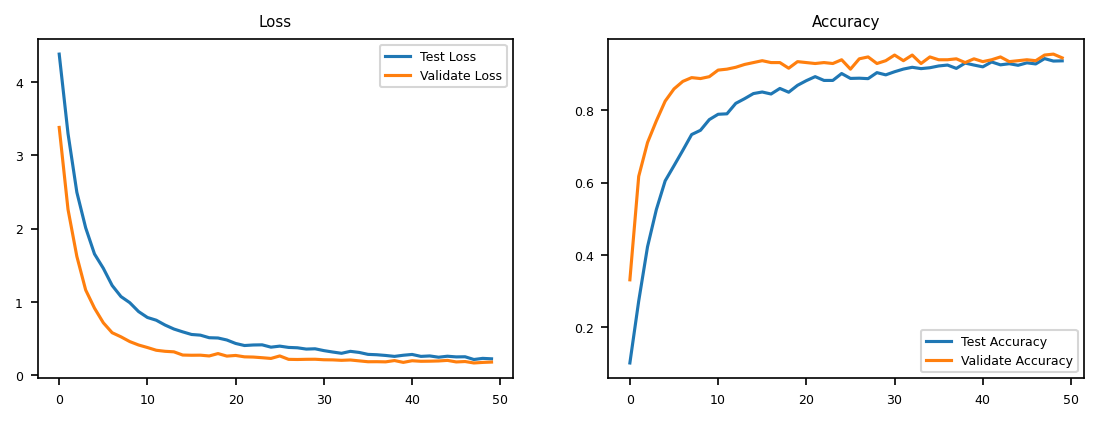

In [93]:
f,ax = plt.subplots(1,2, dpi=150, figsize=(9,3))
ax[0].plot(history.history['loss'], label='Test Loss')
ax[0].plot(history.history['val_loss'], label='Validate Loss')
ax[0].set_title("Loss")
ax[0].legend()
ax[1].plot(history.history['accuracy'], label='Test Accuracy')
ax[1].plot(history.history['val_accuracy'], label='Validate Accuracy')
ax[1].set_title("Accuracy")
ax[1].legend()


In [94]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Sprawdzamy wynik na danych testowych.

In [95]:
new_model_transfer.evaluate(test_ds)

15/15 [==============================] - 0s 19ms/step - loss: 0.2059 - accuracy: 0.9354


[0.20592428743839264, 0.9354166388511658]

In [96]:
new_model.predict(test_ds)

array([[0.        , 0.        , 0.4130524 , ..., 0.19015126, 0.        ,
        0.        ],
       [0.        , 0.14352122, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.15651764, 0.        , 0.18031049, ..., 0.5322199 , 0.        ,
        0.        ],
       ...,
       [0.02054877, 0.        , 0.31168365, ..., 0.25108573, 0.00263167,
        0.01571401],
       [0.        , 0.        , 0.        , ..., 0.28044617, 0.12043592,
        0.02095376],
       [0.        , 0.        , 0.29203728, ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

Wykorzystując metodę głosowania większościowego wybieramy klasę. Technicznie określamy numer kolumny w każdym wierszu zwracanym przez sieć `pred` o wartości nawiększego prawdopodobieństwa. Pamiętamy, że keras obliczy wartości dla całego batcha o zawierającego 32 obrazy, zwróci zatem macierz o rozmiarach: 32 wierszy na 20 kolumn.

In [97]:
def debug(msg):
    pass
    # print(msg) # odkomentuj jeżeli chcesz obejrzeć wartości

images = []
y_true = []
y_pred = []
for batch in test_ds:
    pred = new_model_transfer.predict(batch[0])
    print(batch[1])
    print(pred)
    for idx, (prawdopodobienstwo, oczekiwane) in enumerate(zip(pred, batch[1])):
        debug(f"oczekiwana: {oczekiwane} obliczona : {np.argmax(prawdopodobienstwo)}")

        images.append(batch[0][idx,:,:,:]) # zapamietaj skojarzony obrazek
        y_true.append(oczekiwane)          # zapamiętaj wartosć rzeczywistą
        y_pred.append(np.argmax(prawdopodobienstwo)) # zapamiętaj pozycję z największym prawdopodobieństwem

y_true = np.array(y_true)
y_pred = np.array(y_pred)

tf.Tensor(
[ 37  30  41 102  57   1 106 100  11 104  44  13  56  38  24 105   8   9
  90  29 100  37 100  98  66  76  54  11   2  93  59  47], shape=(32,), dtype=int32)
[[1.06219254e-07 6.04831655e-07 3.51333654e-07 ... 2.38242501e-06
  1.08029883e-06 1.06284015e-05]
 [1.96026615e-03 2.55754450e-03 1.85818019e-04 ... 1.88301033e-06
  1.52187977e-05 6.55592521e-06]
 [2.75401226e-06 7.77573041e-06 3.45604349e-07 ... 8.39636698e-08
  2.09593040e-07 1.82279416e-06]
 ...
 [1.12527014e-05 6.77827193e-05 3.39702019e-05 ... 8.23611917e-05
  1.25778920e-03 1.63088625e-05]
 [6.26676832e-04 3.84820169e-06 5.91881399e-05 ... 9.78841344e-05
  2.18104196e-06 5.19286596e-06]
 [8.34216538e-04 2.45621894e-04 1.21387791e-04 ... 8.40832305e-04
  1.67384991e-04 6.77581920e-05]]
tf.Tensor(
[ 53  14  55 112  98  99   8   1  26   7  77 112   5   0  88 100  46  20
 104  93  99  48  29  43  36 107  68  83   8  50  65  13], shape=(32,), dtype=int32)
[[7.5441160e-11 3.4075079e-08 2.3599955e-09 ... 3.5741546e-10


tf.Tensor(
[ 41  97  18  90  78  66  51   9  43  28  39  31  73  44  14  13 102  68
  49  52  82  94  27  67  21  22  85  97 105  56 108  48], shape=(32,), dtype=int32)
[[8.3075371e-05 9.3905073e-06 1.5569096e-05 ... 1.2320238e-06
  3.0077392e-06 3.6784299e-05]
 [3.7197642e-06 2.8963088e-06 1.0234249e-06 ... 5.7998782e-06
  6.6554334e-05 6.5437857e-06]
 [4.4433045e-06 1.3351862e-03 2.9228340e-05 ... 1.5252099e-06
  7.0455076e-06 3.0561691e-06]
 ...
 [4.0031793e-08 3.4036017e-05 4.9762393e-06 ... 2.8809851e-08
  5.6549874e-07 2.7681034e-07]
 [1.0882193e-09 1.3623828e-07 2.6798409e-07 ... 1.1622128e-08
  1.5247780e-07 1.5742017e-07]
 [5.5928227e-05 4.5292472e-04 4.3760444e-04 ... 7.6904318e-05
  1.2541225e-02 1.1896394e-02]]
tf.Tensor(
[ 64 103  97   1  82 104  60  77   8 100  18  93 104  60  28 110   5  53
  29  82   1  43  51  86  56  38  51  35  73  60  12  76], shape=(32,), dtype=int32)
[[1.43181129e-08 1.72743694e-06 9.83626265e-08 ... 1.79181185e-08
  9.06900368e-07 4.13855616e-07]

In [98]:
confusion_matrix(y_pred, y_true)

array([[5, 0, 0, ..., 0, 0, 0],
       [0, 7, 0, ..., 0, 0, 0],
       [0, 0, 3, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 5, 0, 0],
       [0, 0, 0, ..., 0, 7, 0],
       [0, 0, 0, ..., 0, 0, 2]], dtype=int64)

In [99]:
print(classification_report(y_pred, y_true))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.88      1.00      0.93         7
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         4
           6       1.00      0.71      0.83         7
           7       1.00      1.00      1.00         4
           8       1.00      0.83      0.91         6
           9       1.00      1.00      1.00         4
          10       1.00      1.00      1.00         3
          11       0.80      1.00      0.89         4
          12       0.60      1.00      0.75         3
          13       1.00      1.00      1.00         7
          14       1.00      1.00      1.00         5
          15       1.00      1.00      1.00         2
          16       1.00      1.00      1.00         2
          17       1.00    

G:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Znajdź wszystkie przypadki błędnie sklasyfikowane, aby móc je obejrzeć.

In [100]:
blednie_sklasyfikowane = np.where( y_true != y_pred )
blednie_sklasyfikowane

(array([ 52,  62,  84, 103, 110, 150, 154, 156, 157, 172, 174, 183, 215,
        222, 226, 228, 250, 260, 269, 375, 396, 418, 421, 439, 458, 459,
        462, 469], dtype=int64),)

In [101]:
@interact(idx=blednie_sklasyfikowane[0].tolist())
def show_image(idx):
    # skalujemy znormalizowane dane do palety kolorów RGB(255,255,255) 
    img = (images[idx].numpy() -np.min(images[idx].numpy())) * 255 / (np.max(images[idx].numpy()) - np.min(images[idx].numpy()))

    plt.figure(dpi=150)
    plt.imshow(img.astype(np.uint8))
    plt.title(f"Oczekiwane: {classno_to_charname(dataset[y_true[idx]])}, Obliczone: {classno_to_charname(dataset[y_pred[idx]])}")

interactive(children=(Dropdown(description='idx', options=(52, 62, 84, 103, 110, 150, 154, 156, 157, 172, 174,…

Przekonwertujemy wektor klas do kodowania one-hot-encoding (kazda kolumna będzie osobną klasą wartość 1 oznacza przynależnośc do danej klasy, wartość 0 - nie). W każdym wierszu macierzy będzie tylko jedna wartość niezerowa.

In [102]:
idx = np.where( y_true == 0 )
y_true_hot_one = np.zeros( (y_true.shape[0], numClasses) )
for idx, c in enumerate(y_true):
    y_true_hot_one[idx, c] = 1.0
#y_true_hot_one

Obliczmy wartości predykcji za pomocą nauczonego modelu. Używamy listy obrazków, które pobraliśmy dla dwóch batchy? (64 obrazki) - część się powtarza. 

In [103]:
y_pred_keras = new_model_transfer.predict((np.array(images)))

Analizujemy wyniki bardzo szeczegółowo. Chcemy pokazać oryginalną klasę, klasę wyznaczoną przez sieć (numer kolumny z maksymalnym prawdopodobieństwem obliczonym przez ostatnią warstwę sieci - Softmax), wartość maksymalnego prawdopodobieństwa dla danego przypadku oraz wartość drugiego co do wielkości prawdopodobieństwa. Porównanie dwóch ostatnich wielkości pokazuje nam stopień pewności klasyfikacji danego przypadku.

In [104]:
print(f"Rozmiar macierzy zawierającego zawierającej prawdopodobieństwa przynależności do danej klasy: {y_pred_keras.shape}")
print(f"{'-'*110}")

res = []
print("Klasy oczekiwane, oraz prawdopodobieństwa obliczone dla maksymalnej klasy w formie listy.")
for y_t, y_p in zip(y_true, y_pred_keras):
    y_p_sorted = np.sort(y_p)
    res.append( (y_t, np.argmax(y_p), y_p_sorted[-1], y_p_sorted[-2]) )
    #print(f"Klasa rzeczywista: {y_t:4}, Klasa obliczona (nr maksymalnego P_max): {np.argmax(y_p)}, P_max: {y_p_sorted[-1]:.2f}, P_max_2: {y_p_sorted[-2]:.2f}")

# używamy Pandas i Dataframe tylko po to aby ładnie wyświetlić wyniki    
df = pd.DataFrame(data=res, columns=["Klasa rzeczywista", "Klasa obliczona (nr. max. P_max)", "P_max", "P_max_2"])
pd.set_option('display.max_rows', 100)
df = df.sort_values("Klasa rzeczywista")
display(df)

Rozmiar macierzy zawierającego zawierającej prawdopodobieństwa przynależności do danej klasy: (480, 115)
--------------------------------------------------------------------------------------------------------------
Klasy oczekiwane, oraz prawdopodobieństwa obliczone dla maksymalnej klasy w formie listy.


,Klasa rzeczywista,Klasa obliczona (nr. max. P_max),P_max,P_max_2
256,0,0,0.997516,0.000630
368,0,0,0.997899,0.000678
121,0,0,0.998550,0.000418
384,0,0,0.981284,0.007813
45,0,0,0.998823,0.000244
...,...,...,...,...
263,113,113,0.994284,0.004541
65,113,113,0.978873,0.017908
181,113,113,0.998734,0.000583
151,114,114,0.959971,0.032296


Narysujemy krzywą ROC dla każdej klasy osobno oraz w legendzie napiszemy wartość powierzchni pod krzywą: AUC (ang. area under curve). Wykresy będą dość 'kańciaste' ponieważ nasz zbiór testowy jest stosunkowo mały.

AUC dla klasy: 1: 1.0
AUC dla klasy: 2: 1.0
AUC dla klasy: 3: 1.0
AUC dla klasy: 4: 1.0
AUC dla klasy: 5: 1.0
AUC dla klasy: 6: 1.0
AUC dla klasy: 7: 1.0
AUC dla klasy: 8: 1.0
AUC dla klasy: 9: 1.0
AUC dla klasy: 10: 1.0
AUC dla klasy: 11: 1.0
AUC dla klasy: 12: 1.0
AUC dla klasy: 13: 0.9991578947368421
AUC dla klasy: 14: 1.0
AUC dla klasy: 15: 1.0
AUC dla klasy: 16: 1.0
AUC dla klasy: 17: 1.0
AUC dla klasy: 18: 1.0
AUC dla klasy: 19: 1.0
AUC dla klasy: 20: 1.0
AUC dla klasy: 21: 1.0
AUC dla klasy: 22: 1.0
AUC dla klasy: 23: 1.0
AUC dla klasy: 24: 1.0
AUC dla klasy: 25: 1.0
AUC dla klasy: 26: 1.0
AUC dla klasy: 27: 1.0
AUC dla klasy: 28: 1.0
AUC dla klasy: 29: 0.9963235294117647
AUC dla klasy: 30: 1.0
AUC dla klasy: 31: 0.9994747899159664
AUC dla klasy: 32: 0.9987368421052633
AUC dla klasy: 33: 0.9984243697478992
AUC dla klasy: 34: 1.0
AUC dla klasy: 35: 1.0
AUC dla klasy: 36: 0.9968619246861924
AUC dla klasy: 37: 1.0
AUC dla klasy: 38: 1.0
AUC dla klasy: 39: 1.0
AUC dla klasy: 40: 1.0

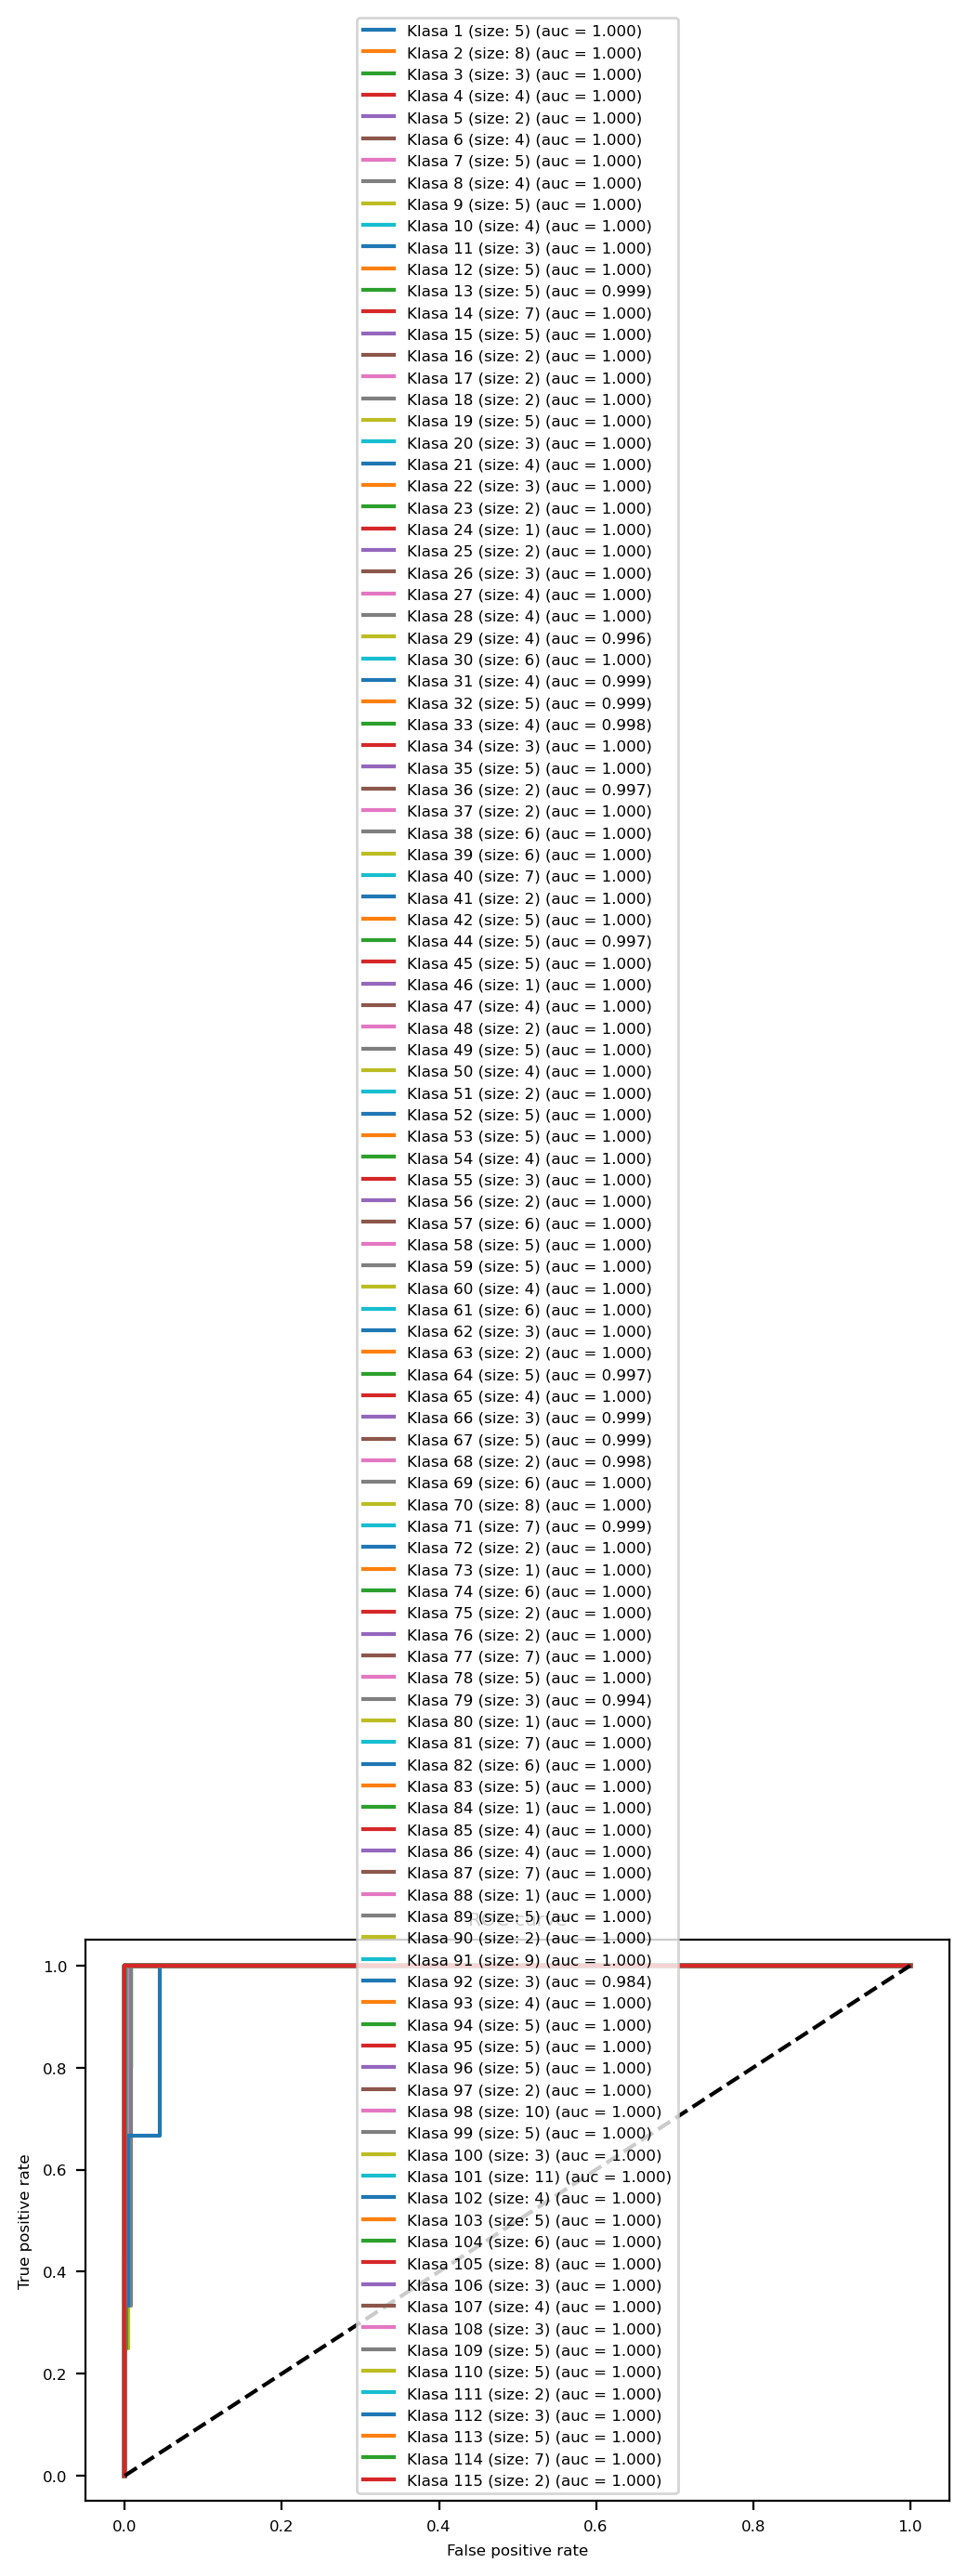

In [105]:
plt.figure(1, dpi=200)
for i in range(numClasses):
    if (np.sum(y_true_hot_one[:,i]) > 0):
        fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_true_hot_one[:,i], y_pred_keras[:,i])
        auc_keras = auc(fpr_keras, tpr_keras)
        print(f"AUC dla klasy: {i+1}: {auc_keras}")

        plt.plot(fpr_keras, tpr_keras, label=f'Klasa {i+1} (size: {np.sum(y_true_hot_one[:,i]).astype(np.uint)}) (auc = {auc_keras:.3f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


Teraz narysujemy zbiorczy ROC dla wszystkich klas. Wykonamy to w ten sposób, że weźmiemy macierze: przynależności do klas (one-hot-encoded) oczekiwane -zera i jedynki oraz prawdopodobieństwa przynależności do danej klasy obliczone za pomocą sieci. Następnie przekształcimy obie macierze do postaci wektorowej (wierzami, za pomocą funkcji `ravel()`). 

Gotowe wektory:

* `y_true_hot_one.ravel()` - zawierający wartości `0` i `1`
* `y_pred_keras.ravel()` - zawierający prawdopodobieństwa $p_i \in <0,1>$

przekażemy do funkcji generującej krzywą ROC.

AUC zbiorczy: 0.9996849491349902


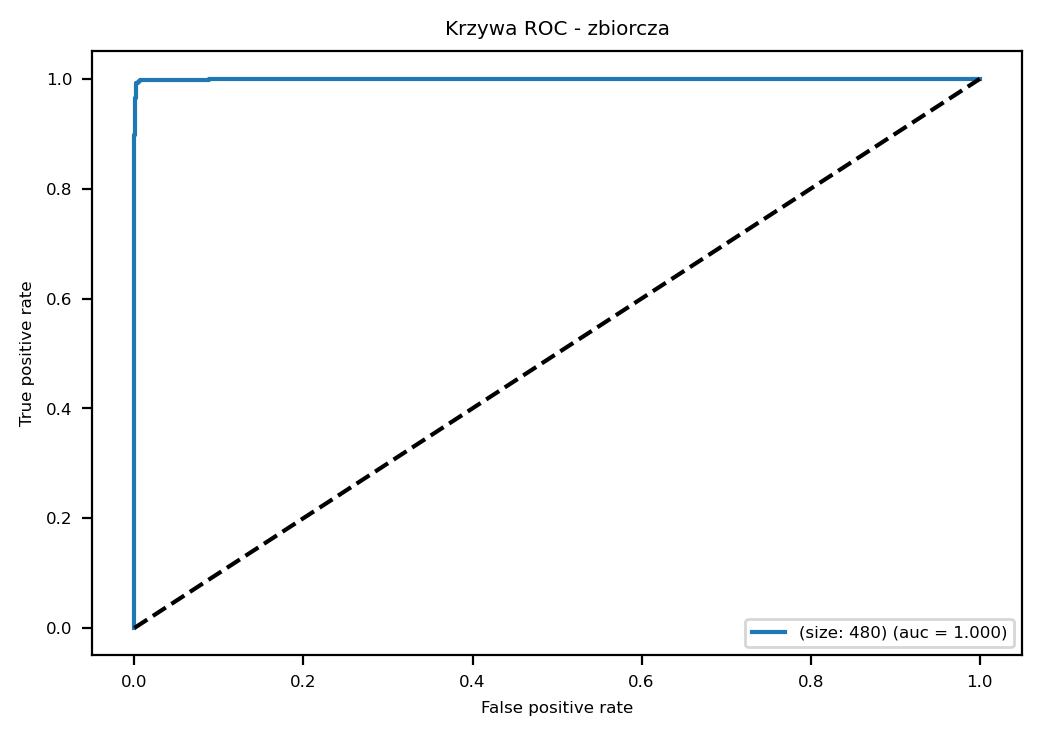

In [106]:
# ROC zbiorczy

y_pred_keras = new_model_transfer.predict((np.array(images)))
y_pred_keras.shape

plt.rc('font', size=6) 
plt.figure(1, dpi=200)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_true_hot_one.ravel(), y_pred_keras.ravel())
auc_keras = auc(fpr_keras, tpr_keras)
print(f"AUC zbiorczy: {auc_keras}")

plt.plot(fpr_keras, tpr_keras, label=f'(size: {len(y_true)}) (auc = {auc_keras:.3f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Krzywa ROC - zbiorcza')
plt.legend(loc='best')
plt.show()